In [1]:
import pandas as pd
#import random 
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Below is only for local testing purpuse, not included in submissison
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import itertools
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix


# Below model if not choosen is not necessary 
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

#from sklearn.model_selection import train_test_split
import nltk
## Download Resources
nltk.download('punkt')
nltk.download('words')
from nltk.corpus import words
#from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

############
! pip install syllables
import syllables
import string
from scipy.sparse import coo_matrix, hstack


[nltk_data] Downloading package punkt to /Users/pingwu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/pingwu/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
def appendArticles(articleList, basePath):
    contents = ''
    for articleNumber in articleList:
        f = open(basePath+str(articleNumber)+".txt", "r")
        contents = f.read()+";"+contents
        f.close()
    return contents

In [3]:
basePath = os.path.dirname(os.path.abspath("train.json"))
# 0:false, 1:partly true, 2:true
claim = pd.read_json(open(basePath + "/train/train.json", "r", encoding="utf8"))
txtPath = basePath+"/train/train_articles/"

In [4]:
claim['articleText'] = claim.apply(lambda row: appendArticles(row['related_articles'], txtPath) ,axis=1)

In [5]:
def startNumber(text):
    if text[:1].isdigit():
        return 1
    else:
        return 0

def containQuestion(text):
    if '?' in text or '!' in text:
        return 1
    else:
        return 0
    
def numberSyllable(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    number_words = len(text.split())
    total = 0
    for word in text.split():
        total += syllables.estimate(word)
    return total/number_words

def assignLength(row, colName):
    return len(row[colName])

In [6]:
sid = SentimentIntensityAnalyzer()
claim['claimSentiment'] = claim.apply(lambda row: sid.polarity_scores(row['claim'])['compound'] ,axis=1)
claim['SentimentAdjust'] = claim['claimSentiment']+1

In [7]:
#check if claim starts with a number
claim['start_number'] = claim.apply(lambda row: startNumber(row['claim']) ,axis=1)

In [8]:
#check if claim contain any ? or !
claim['containQX'] = claim.apply(lambda row: containQuestion(row['claim']) ,axis=1)
#number of words in the claim
claim['titleWords'] = claim.apply(lambda row: len(row['claim'].split()) ,axis=1)
#number of related articles to the claim
claim['numberArticle'] = claim.apply(lambda row: len(row['related_articles']) ,axis=1)
#number of average syllables in each word in the claim
claim['claimSyllable'] = claim.apply(lambda row: numberSyllable(row['claim']) ,axis=1)
claim['articleLength'] = claim.apply(lambda row: assignLength(row, 'articleText'), axis=1)
#average length of word in related articles to the claim
#claim['articleLength'] = claim.apply(lambda row: assignLength(row, 'articleText')/row['numberArticle'], axis=1)
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
#get number of punctuation in the claim
claim['claimPunc'] = claim.apply(lambda row: count(row['claim'],set(string.punctuation)), axis=1)
#get number of punctuation in each related articles
claim['articlePunc'] = claim.apply(lambda row: count(row['articleText'],set(string.punctuation))/row['numberArticle'], axis=1)


In [26]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/Users/pingwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/pingwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/pingwu/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


accuracy:   0.593
Confusion matrix, without normalization


/Users/pingwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/pingwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/pingwu/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


accuracy:   0.596
Confusion matrix, without normalization


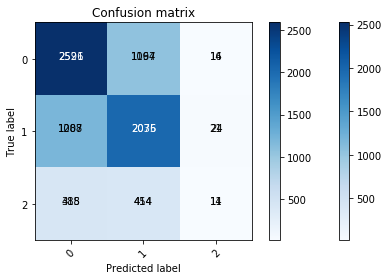

In [27]:
n_splits = 2
kfold = KFold(n_splits=n_splits)
kfold.get_n_splits(claim)
for train_idx, test_idx in kfold.split(claim):
    X_train, X_test = claim.iloc[train_idx], claim.iloc[test_idx]    
    y_train, y_test = X_train['label'], X_test['label']
    X_train_text, X_test_text= X_train['articleText'], X_test['articleText']
    
    # Initialize the `tfidf_vectorizer` 
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', \
                                       ngram_range=(2, 2), max_df=0.7, max_features=3000) 
    # Fit and transform the training data 
    tfidf_train = tfidf_vectorizer.fit_transform(X_train_text) 
    # Transform the test set 
    tfidf_test = tfidf_vectorizer.transform(X_test_text)

    featureToBeAdded = ['SentimentAdjust',\
                        #'claimSentiment',\
                        'numberArticle','articleLength',\
                        'start_number',\
                        'containQX', \
                        'titleWords',\
                        'claimSyllable',\
                        'claimPunc', 'articlePunc',\
                       ]
    combResults = tfidf_train
    for featureName in featureToBeAdded:
        colToBeAdded = coo_matrix(X_train[featureName]).transpose()
        combResults = hstack([combResults, colToBeAdded])

    combResultsTest = tfidf_test
    for featureName in featureToBeAdded:
        colToBeAdded = coo_matrix(X_test[featureName]).transpose()
        combResultsTest = hstack([combResultsTest, colToBeAdded])

    #multi_class : str, {‘ovr’, ‘multinomial’, ‘auto’}, optional (default=’ovr’)
    #solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, optional (default=’liblinear’).
    clf = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial')
    #clf = MultinomialNB() 
    #clf = ComplementNB()
    #clf =  SVC()
    #clf = PassiveAggressiveClassifier(tol=50)
    clf.fit(combResults, y_train)
    pred = clf.predict(combResultsTest)
    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    cm = confusion_matrix(y_test, pred, labels=[0, 1, 2])
    plot_confusion_matrix(cm, classes=[0, 1, 2])